<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/tonic_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connects colab to drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/AA/Code/')

Mounted at /content/drive


In [51]:
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import pandas as pd
%matplotlib inline

def print_plot_play(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(10, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

# Read wav
string=  " - Mohanakrishnana"
fn_wav = os.path.join('/content/drive/My Drive/AA/Music dataset/Tonic_Source_Separation',string,'vocals.mp3')
# fn_wav ='/content/drive/My Drive/Projects/AA/Music dataset/Tonic_source_separation/Bombay Jayashri - Sri Matrubhutam/vocals.wav'
# x, Fs = librosa.load(fn_wav, sr=None,duration= 100)
# print_plot_play(x=x, Fs=Fs, text='WAV file: ')


A_Sa_candidates : [122.75703125 127.24212598 131.35168539]
check : 4.305541422573549  Tonic : 122.75703125000001
self.finallist : [122.75703125 127.24212598 131.35168539]
A_Sa_candidates : [122.75703125 127.24212598 131.35168539]
check : 4.305541422573549  Tonic : 122.75703125000001


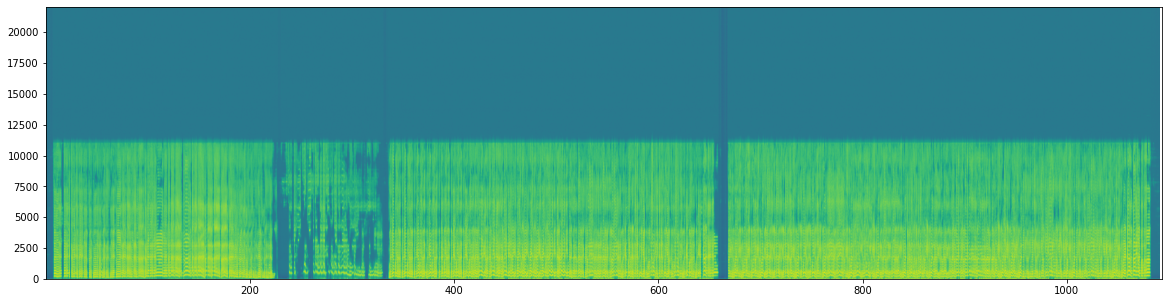

In [70]:
test=Audio(fn_wav)

In [71]:
test.tonic

122.75703125000001

In [72]:
test.Sa_candidates

defaultdict(list,
            {'Ri2': 114.70769230769233,
             'lDa1': 131.89555555555555,
             'lDa2': 131.35168539325844,
             'lNi2': 127.24212598425197,
             'lNi3': 122.75703125000001})

In [73]:
test.tonic_candidates

[103.9,
 104.2,
 105.6,
 106.7,
 108.4,
 109.0,
 109.4,
 109.7,
 110.1,
 110.4,
 110.7,
 111.2,
 111.4,
 111.8,
 112.4,
 112.8,
 114.0,
 115.1,
 115.4,
 116.5,
 116.7,
 116.9,
 117.7,
 118.0,
 119.8,
 120.3,
 121.4,
 122.4,
 122.7,
 123.2,
 125.1,
 125.5,
 125.9,
 126.4,
 126.7,
 127.1,
 127.6,
 128.3,
 129.2,
 129.9,
 130.4,
 130.6,
 131.2,
 131.7,
 131.9,
 132.3,
 132.5,
 133.0,
 133.4,
 134.2]

In [69]:
import librosa
import librosa.display
from swipe import *
from scipy import signal
import math
from collections import defaultdict, OrderedDict
import statistics
import copy
import json
import os
plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None): 
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.constant_pitch()
    self.find_gamaka()
    self.find_stationary_points()
    self.develop_histogram(cpn = True)
    self.tonic = self.find_tonic()
    # self.normalize()
    # self.develop_histogram(cpn = False)
    # self.histogram()
    # self.find_all_notes()
    # self.sequence_notes = self.find_sequence_notes(parameter = self.all_notes)
    # self.pattern=self.find_pattern()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    
  def constant_pitch(self ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
  
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = np.array([item for sublist in g for item in sublist])
    self.cpt = np.array([item for sublist in h for item in sublist])
  
  def find_all_notes(self):  
    self.all_notes = []
    for i in self.n_pitch:
      if i in self.n_cpn or i in self.n_stp:
        self.all_notes.append(i)

  def find_gamaka(self):
    ta = list(self.time_axis)
    self.bt_cpn = []
    self.bt_cpt = []
    init = 0
    for _,j in self.cpn_and_t:
      if(j):
        begin = int(100*init)
        end = int(100*j[0])
        temp = self.pitch[begin:end]
        self.bt_cpn.append(temp)
        self.bt_cpt.append(ta[begin:end])
        init = j[-1]

  def find_stationary_points(self):
    self.stp = []
    self.stp_t = []
    for i in range(len(self.bt_cpn)):
      test = self.bt_cpn[i]
      test_time  = self.bt_cpt[i]
      for i in signal.find_peaks(test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
      for i in signal.find_peaks(-1*test)[0]:
        self.stp.append(test[i])
        self.stp_t.append(test_time[i])
  def develop_histogram(self,cpn):
    if(cpn):
      d = list(self.cpn) + list(self.stp)
      values=[x for x in d if (math.isnan(x) == False)]
      initial = 120
      end = 500
      increment = 1
      r = 0
    else:
      values = [x for x in self.n_pitch if (math.isnan(x) == False)]
      initial = all_normalized_notes['lSa0']
      end = all_normalized_notes['hNi3']
      increment = 0.01
      r = 2
    # values.extend(self.stp)
    values=[round(x,r) for x in values]
    occur=dict()
    self.d_hist=defaultdict(int)
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=initial
    while(j<=end):
      # print(j)
      if(j in occur):
        self.d_hist[j]=occur[j]
        # times.append(occur[j])
      else:
        self.d_hist[j]=0
      j+=increment
      j = round(j,r)
  
  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.n_pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.n_cpn,c='0',label = 'Constant Pitch')
      if(key =='stp' and value):
        plt.scatter(self.stp_t,self.n_stp,c='#00FF00',label = 'Stationary Points')
        # plt.plot(self.time_axis,self.n_pitch,c="#FF0000",label = 'Pitch Contour')
      if(key =='histogram' and value):
        plt.plot(self.hist_bins,  self.n_hist_y,label = "histogram")
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)



  def find_tonic(self):
    def template_checker(notess,A_Sa_candidates,self):
      
      A_Sa_candidates=list(set(A_Sa_candidates))
      A_Sa_candidates=sort(A_Sa_candidates)
      print("A_Sa_candidates :",A_Sa_candidates)
    # print(len(A_Sa_candidates))

      #############################################################################################

      
      for tonic in A_Sa_candidates:
          # unn_notes=  np.concatenate([obj.cpn,obj.stp])
          # unn_notes=obj.cpn
          un_notes= notess


          n_notes = [12*np.log2(i/tonic) for i in un_notes]
          parameter = n_notes
          cummdiff=0
          
          # print(cummdiff)
          for i in parameter:
          #generates error for every tonic  
            # globdiff=100000000000000000000000000000000000000000
            for j,k in self.enables.items():
              #generates error for every note
              try:
                  if(abs(i - k)<globdiff):
                    globdiff = abs(i-k)
              except:
              #     # print("globdiff not initialized")
              #     # print(i)
                  globdiff=abs(i-k)
            if(globdiff<10):
              cummdiff=cummdiff+globdiff
          # print("Tonic :",tonic," cummdiff :",cummdiff)
            # print(globdiff)
          
          del globdiff

          # print(cummdiff)
          try :
            if(cummdiff<check):
              check=cummdiff
              actual_tonic = tonic
              print("check :",check, " Tonic :",actual_tonic)
          except:
            check = cummdiff
            actual_tonic = tonic
              # print("hi")
            print("check :",check, " Tonic :",actual_tonic)

          
          # print(actual_tonic)
      if(actual_tonic>250):
        # print("Tonic :",actual_tonic/2)
        T_actual_tonic=actual_tonic/2
        return(T_actual_tonic)
      else:
        # print("Tonic :",actual_tonic)
        T_actual_tonic=actual_tonic
        return(T_actual_tonic)
    def close_5(arr):
      if(len(arr)<6):
        return arr
      top5=list()
      for i in arr:
        count=0
        for j in arr:
          if(abs(i-j)<16):
            count+=1
        if (count>len(arr)/2):
          top5.append(i)
      return(top5)
    def close_100(arr):
      top5=list()
      for i in arr:
        count=0
        for j in arr:
          if(abs(i-j)<70):
            count+=1
        if (count>len(arr)/2):
          top5.append(i)
      return(top5)
    def toniclist(self) :
      un_notes=[]
      for i in list(self.cpn):
       
        if(not(np.isnan(i))):
            un_notes.append(round(i,1))
      un_notes.sort()

      occur={}
      hist=defaultdict(int)
      for i in un_notes:
            if(i in occur):
              occur[i]+=1;
            else:
              occur[i]=1;
      # soccur = sorted(occur.items(), key=lambda x: x[1], reverse=True)
      # print("soccur :",soccur )
      # occurvalues=list(occur.values())
      #from collections import OrderedDict 
      # soccur = OrderedDict(sorted(occur.items()))
      self.occur = occur
      self.soccur={k: v for k, v in sorted(occur.items(), key=lambda item: item[1],reverse=True)} 
      # print("soccur :",self.soccur )
      occurvalues=list(occur.values())
      # occurvalues=[]
      # for i in soccur:
      #   occurvalues.append(i[0])
      indexlist=[]
      for i in range(1,len(occurvalues)-1):
        if((occurvalues[i-1]<occurvalues[i])and(occurvalues[i+1]<occurvalues[i])):
          indexlist.append(i)
      it=0
      toniclist=[]
      for i in occur:
        it+=1
        if(it in indexlist):
          # print(i," : ",occur[i])
          if(i>100):
            toniclist.append(i)
            # print(i," : ",occur[i])
      return_toniclist=sorted(toniclist)
      return_toniclist=toniclist[:50]
      return(return_toniclist)
    
    def remove_outliers(an_array):
      if(len(an_array)<3):
        return(an_array)
      else:  
        mean=statistics.mean(an_array)
        an_array = np.array(an_array)
        # mean = np.mean(an_array)
        standard_deviation = np.std(an_array)
        distance_from_mean = abs(an_array - mean)
        max_deviations = 0.9
        not_outlier = distance_from_mean <= 1.1* max_deviations * standard_deviation
        no_outliers = an_array[not_outlier]

        return(no_outliers)
  
    def half_the_Sa(ton):

        if(ton>240):
          return (ton/2)
        else:
          return ton
    self.enables={}
    notess=[]
    Sa_candidates=defaultdict(list)
    self.tonic_candidates=toniclist(self)
    Sa_tonic_candidates=[x for x in self.tonic_candidates if x>110 and x<240]
    # print("Tonic candidates :",self.tonic_candidates)
    for i in self.tonic_candidates:
      for j in Sa_tonic_candidates :
            self.enables["Sa0"]=all_normalized_notes["Sa0"]

            if(((i/j)>1.48) and ((i/j) <1.51)):
              Sa_candidates["Pa"].append(half_the_Sa(j))
              self.enables["Pa"]= all_normalized_notes["Pa0"]
              self.enables["lPa"]= all_normalized_notes["lPa0"]
              self.enables["hPa"]= all_normalized_notes["hPa0"]
              notess.append(i);notess.append(j)


            # if(((i/j)>1.06) and ((i/j) <1.067)):
            #   Sa_candidates["Ri1"].append(half_the_Sa(j))
            #   notess.append(i);notess.append(j)
            #   self.enables["Ri1"]= all_normalized_notes["Ri1"]
            #   self.enables["lRi1"]= all_normalized_notes["lRi1"]
            #   self.enables["hRi1"]= all_normalized_notes["hRi1"]


            # if(((i/j)>1.19) and ((i/j) <1.21)):
            #   Sa_candidates["Ga2"].append(half_the_Sa(j))
            #   notess.append(i);notess.append(j)
            #   self.enables["Ga2"]= all_normalized_notes["Ga2"] 
            #   self.enables["lGa2"]= all_normalized_notes["lGa2"]
            #   self.enables["hGa2"]= all_normalized_notes["hGa2"]


            if(((i/j)>1.12) and ((i/j) <1.127) ):
              Sa_candidates["Ri2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ri2"]= all_normalized_notes["Ri2"]
              self.enables["lRi2"]= all_normalized_notes["lRi2"]
              self.enables["hRi2"]= all_normalized_notes["hRi2"]


            if(((i/j)>1.4) and ((i/j) <1.42) ):
              Sa_candidates["Ma2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ma2"]= all_normalized_notes["Ma2"]
              self.enables["lMa2"]= all_normalized_notes["lMa2"]
              self.enables["hMa2"]= all_normalized_notes["hMa2"]


            if(((i/j)>1.31) and ((i/j) <1.34) ):
              Sa_candidates["Ma1"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ma1"]= all_normalized_notes["Ma1"]
              self.enables["lMa1"]= all_normalized_notes["lMa1"]
              self.enables["hMa1"]= all_normalized_notes["hMa1"]


            # if(((i/j)>1.23) and ((i/j) <1.27)):
            #   Sa_candidates["Ga3"].append(half_the_Sa(j))
            #   notess.append(i);notess.append(j)
            #   self.enables["Ga3"]= all_normalized_notes["Ga3"]
            #   self.enables["lGa3"]= all_normalized_notes["lGa3"]
            #   self.enables["hGa3"]= all_normalized_notes["hGa3"]


            if(((i/j)>1.59) and ((i/j) <1.61)):
              Sa_candidates["Da1"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Da1"]= all_normalized_notes["Da1"]
              self.enables["lDa1"]= all_normalized_notes["lDa1"]
              self.enables["hDa1"]= all_normalized_notes["hDa1"]


            if(((i/j)>1.64) and ((i/j) <1.69)):
              Sa_candidates["Da2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Da2"]= all_normalized_notes["Da2"]
              self.enables["lDa2"]= all_normalized_notes["hDa2"]
              self.enables["hDa2"]= all_normalized_notes["hDa2"]
            
            if(((i/j)>1.7) and ((i/j) <1.85) ):
              Sa_candidates["Ni2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ni2"]= all_normalized_notes["Ni2"]
              self.enables["lNi2"]= all_normalized_notes["lNi2"]
              self.enables["hNi2"]= all_normalized_notes["hNi2"]


            if(((i/j)>1.86) and ((i/j) <1.91) ):
              Sa_candidates["Ni3"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ni3"]= all_normalized_notes["Ni3"]
              self.enables["lNi3"]= all_normalized_notes["lNi3"]
              self.enables["hNi3"]= all_normalized_notes["hNi3"]


            
            if(((i/j)>1.98) and ((i/j) <2.2) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Sa2"]= all_normalized_notes["Sa2"]
              self.enables["lSa0"]= all_normalized_notes["lSa0"]
              self.enables["hSa2"]= all_normalized_notes["hSa2"]

            if(((i/j)>1.98) and ((i/j) <2.2) ):
              Sa_candidates["High_Sa"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Sa2"]= all_normalized_notes["Sa2"]
              self.enables["lSa0"]= all_normalized_notes["lSa0"]
              self.enables["hSa2"]= all_normalized_notes["hSa2"]
            
            if(((i/j)>0.85) and ((i/j) <0.92) ):
              Sa_candidates["lNi2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ni2"]= all_normalized_notes["Ni2"]
              self.enables["lNi2"]= all_normalized_notes["lNi2"]
              self.enables["hNi2"]= all_normalized_notes["hNi2"]

            if(((i/j)>0.92) and ((i/j) <0.95) ):
              Sa_candidates["lNi3"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Ni3"]= all_normalized_notes["Ni3"]
              self.enables["lNi3"]= all_normalized_notes["lNi3"]
              self.enables["hNi3"]= all_normalized_notes["hNi3"]

            if(((i/j)>0.82) and ((i/j) <0.85) ):
              Sa_candidates["lDa2"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Da2"]= all_normalized_notes["Da2"]
              self.enables["lDa2"]= all_normalized_notes["lDa2"]
              self.enables["hDa2"]= all_normalized_notes["hDa2"]
            
            if(((i/j)>0.76) and ((i/j) <0.82) ):
              Sa_candidates["lDa1"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Da1"]= all_normalized_notes["Da1"]
              self.enables["lDa1"]= all_normalized_notes["lDa1"]
              self.enables["hDa1"]= all_normalized_notes["hDa1"]
            
            if(((i/j)>0.7) and ((i/j) <0.75) ):
              Sa_candidates["Pa0"].append(half_the_Sa(j))
              notess.append(i);notess.append(j)
              self.enables["Pa0"]= all_normalized_notes["Pa0"]
              self.enables["lPa0"]= all_normalized_notes["lPa0"]
              self.enables["hPa0"]= all_normalized_notes["hPa0"]
            
            


            if(i>200):  
              if(((i/j)>1.95) and ((i/j) <2.1) ):
                Sa_candidates["High_Sa"].append(half_the_Sa(j))
            # if(j>200):
            #   #Pa
            #   if(((i/j)>0.74) and ((i/j) <0.76) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #   #Da2
            #   if(((i/j)>0.82) and ((i/j) <0.85) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
            #   #Ma
            #   if(((i/j)>0.65) and ((i/j) <0.68) ):
            #     Sa_candidates["High_Sa"].append(half_the_Sa(j/2))
    # print("The Sa_candidates are : ",(Sa_candidates)) 

    for i in Sa_candidates:
      Sa_candidates[i]=remove_outliers(Sa_candidates[i])
    #   Sa_candidates[i]=close_5(Sa_candidates[i])

    if("Pa" in Sa_candidates):
      if(len(Sa_candidates["Pa"])!=0):
            Pa= mean((close_5((Sa_candidates["Pa"]))))
            if("High_Sa" in Sa_candidates):
              if(len(Sa_candidates["High_Sa"])!=0):

                      # if(Pa in Sa_candidates["High_Sa"]):
                      #   High_Sa=Pa
                      # else:
                        High_Sa = mean((close_5((Sa_candidates["High_Sa"]))))
                        # print("High_Sa :",High_Sa)
                        # print("Pa :",Pa)
                        # High_Sa=mean(x)

                        if(abs(High_Sa-Pa)<5 ):
                          #and (High_Sa+Pa) != 0
                              prob = High_Sa
                              # print("SAPSPSAPSPASA")
                              # print(half_the_Sa((prob+Pa)/2))
                              return(half_the_Sa((prob+Pa)/2))     
                            
    
    for i in Sa_candidates:
      # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
        # print("i :",i, " Sa_candidates[i] :", Sa_candidates[i])
      if(len(Sa_candidates[i])!=0):
          Sa_candidates[i]=mean(Sa_candidates[i])
          
    

    temp=[i for i in list(Sa_candidates.values()) if(i)]
    # print("Temp :",temp)

    # temp2=remove_outliers(temp)
    # finallist=close_5(temp2)
    self.finallist=remove_outliers(temp)
    self.Sa_candidates = Sa_candidates
    if(not(np.isnan(template_checker(notess,self.finallist,self)))):
      print("self.finallist :",self.finallist)
      # print((half_the_Sa(mean(finallist))))
      return(template_checker(notess,self.finallist,self))

    else:
      # print("Tonic not found")
      return -1

  def histogram(self):
    self.hist_bins,self.hist_y = np.array(list(self.d_hist.items())).T
    self.n_hist_y = self.hist_y/len(self.pitch)



ratios = {'Sa0':1,'Ri1':16/15,'Ri2':9/8,'Ga2':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa0':3/2,'Da1':8/5,
          'Da2':5/3,'Ni2':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)
  all_normalized_notes['l'+i] = 12*np.log2(0.5*j)
  all_normalized_notes['h'+i] = 12*np.log2(2*j)

del all_normalized_notes['lSa2']
del all_normalized_notes['hSa0']
all_normalized_notes = OrderedDict(sorted(all_normalized_notes.items(),key=lambda kv: kv[1]))

In [ ]:
test.Sa_candidates

defaultdict(list,
            {'Ga2': 183.65897435897432,
             'Ga3': 178.22432432432427,
             'Ma1': 165.3621621621622,
             'Ma2': 162.92222222222222,
             'Ri2': 181.43333333333334})

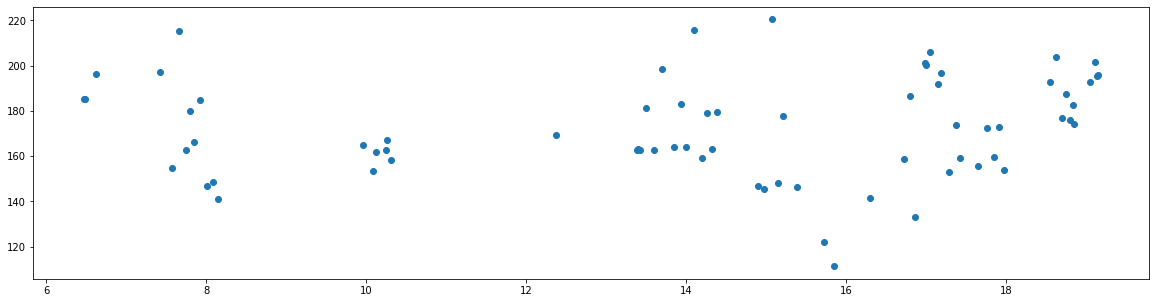

In [ ]:
plt.scatter(test.stp_t[0:70],test.stp[0:70])
# plt.plot(test.time_axis,test.pitch,c= "red")

In [ ]:
all_songs = os.listdir("drive/My Drive/AA/Music dataset/Tonic_source_separation")
all_songs.remove('.ipynb_checkpoints')
all_songs.sort()

In [ ]:
path = "/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/{songname}/vocals.wav"

In [ ]:
f= open("/content/drive/My Drive/AA/Music dataset/compMusicDetails.json",)
compMusicTonicDetails = json.load(f)
f.close()

In [ ]:
x = open("/content/drive/My Drive/AA/Music dataset/our_tonic.json",)
ourTonic = json.load(x)
x.close()
done = []

In [ ]:

to_start = len(ourTonic)

In [ ]:
to_start

35

In [ ]:
all_songs[to_start]

' - Vishweshsra'

 - Vishweshsra


KeyboardInterrupt: ignored

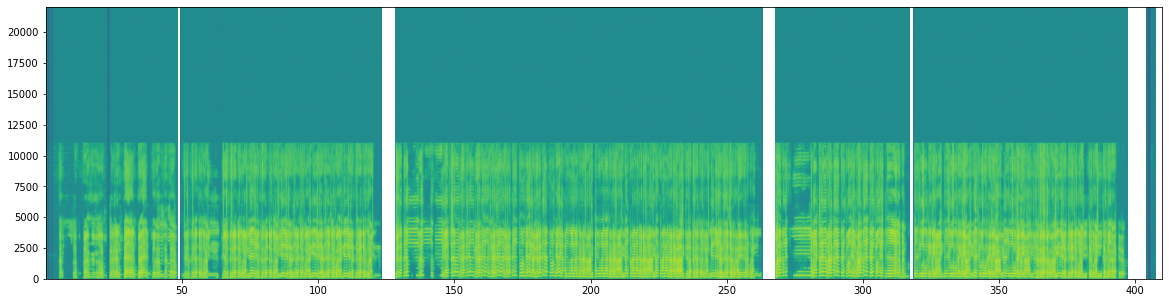

In [ ]:
for i in all_songs[to_start:]:
  print(i)
  song_to_test = Audio1(path.format(songname = i))
  for j in compMusicTonicDetails:
    try:
      if compMusicTonicDetails[j]["songname"].split(".mp3")[0] == i:
        ourTonic[j] = compMusicTonicDetails[j]
        done.append(i)
        ourTonic[j]["Our Tonic"] = song_to_test.tonic
        json_object = json.dumps(ourTonic,indent = 4)
        with open("/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/our_tonic.json", "w") as out:
          out.write(json_object)
        
    except (KeyError, FileNotFoundError) as e:
      pass
  song_to_test = []

  

In [ ]:
json_object = json.dumps(ourTonic,indent = 4)
with open("/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/our_tonic.json", "w") as outfile: 
			outfile.write(json_object)

In [ ]:
song_to_test = []

In [ ]:
a = []
while(1):
    a.append('1')

In [ ]:
del a

NameError: ignored

In [ ]:
all_songs.remove('.ipynb_checkpoints')

In [ ]:
!apt-get upgrade

In [ ]:
!python -c "import numpy"

In [ ]:
import os
import json
five_candidates=[]
ten_candidates=[]
not_working = []
missed=0
path = "/content/drive/My Drive/AA/Music dataset/Tonic_source_separation/"

# all_songs = os.listdir("/home/kodhandarama/Desktop/Raga/Code/Audio_Analysis/lolol")
all_songs = os.listdir(path)
all_songs.remove('.ipynb_checkpoints')
all_songs.sort()
for i in all_songs:
  !python3 '/content/drive/My Drive/AA/Code/main.py' --song "{i}" 
  tonic_file = open('/content/drive/My Drive/AA/Music dataset/our_tonic_ss.json','r')
  data = json.load(tonic_file)
  tonic_file.close()
  for j in data :
    song = data[j]
    if data[j]["songname"].split(".mp3")[0] == i:
      print(song['Tonic'])
      if (abs(song['Tonic']-song['Our Tonic'])<=5):
        five_candidates.append(i)
      elif(abs(song['Tonic']-song['Our Tonic']))<=10:
        not_working.append(i)
        ten_candidates.append(i)
      else:
        not_working.append(i)
        missed +=1

print(five_candidates)
print(not_working)
print(len(five_candidates))
print(len(not_working))

soccur : {100.0: 845, 490.95: 285, 192.04: 100, 192.21: 95, 192.56: 88, 192.39: 86, 192.73: 81, 191.87: 79, 254.04: 79, 254.5: 77, 254.27: 75, 191.69: 68, 386.17: 68, 387.21: 67, 192.91: 66, 254.96: 65, 256.57: 64, 253.81: 63, 255.88: 63, 257.27: 63, 386.86: 63, 255.19: 60, 256.34: 60, 255.65: 59, 254.73: 57, 258.43: 57, 193.26: 56, 191.52: 55, 193.08: 55, 387.91: 55, 256.11: 53, 256.81: 52, 257.04: 52, 255.42: 49, 386.51: 48, 253.35: 47, 253.58: 47, 385.82: 47, 387.56: 44, 257.5: 43, 253.12: 42, 258.67: 42, 252.67: 41, 252.9: 40, 257.73: 38, 388.26: 38, 191.35: 37, 384.43: 37, 193.43: 36, 288.78: 35, 384.77: 35, 385.47: 35, 258.2: 34, 191.18: 32, 289.56: 32, 259.13: 31, 288.25: 31, 291.92: 31, 385.12: 30, 259.84: 29, 287.99: 29, 388.61: 29, 388.96: 29, 252.21: 28, 257.97: 28, 288.51: 28, 289.82: 28, 237.63: 27, 258.9: 27, 287.48: 27, 289.04: 27, 384.08: 27, 290.08: 26, 190.83: 25, 191.0: 25, 289.3: 25, 239.56: 24, 240.43: 24, 259.37: 24, 190.66: 23, 290.34: 23, 290.61: 23, 239.13: 22,

In [ ]:
!python3 '/content/drive/My Drive/AA/Code/main.py' --song "{i}"

 - Anna Purne


In [ ]:
!echo {i}

- Anna Purne


usage: ipykernel_launcher.py [-h] [--song SONG]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-da999e9f-4e34-46f1-bf06-bc06bfa16525.json


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import os
import json
five_candidates=[]
ten_candidates=[]
not_working = []
missed=0

path = "/content/drive/My Drive/AA/Music dataset/Tonic_Source_Separation"

# all_songs = os.listdir("/home/kodhandarama/Desktop/Raga/Code/Audio_Analysis/lolol")
all_songs = os.listdir(path)
# all_songs.remove('.ipynb_checkpoints')
all_songs.sort()
for i in all_songs:
  !python3 '/content/drive/My Drive/AA/Code/main_regression_on_source_separation.py' --song "{i}" 

  tonic_file = open('/content/drive/My Drive/AA/Music dataset/our_tonic_comp_ss_80.json','r+')
  data = json.load(tonic_file)
  tonic_file.close()
  for j in data :
    song = data[j]
    if data[j]["songname"].split('.mp3')[0] == i:
      print(song['Tonic'])
      if (abs(song['Tonic']-song['Our Tonic'])<=5):
        five_candidates.append(i)
      elif(abs(song['Tonic']-song['Our Tonic']))<=10:
        not_working.append(i)
        ten_candidates.append(i)
      else:
        not_working.append(i)
        missed +=1

result = {}
result['five_candidates'] = five_candidates
result['not_working'] = not_working
result['len_five_candidates'] = len(five_candidates)
result['len_not_working'] = len(not_working)
with open('/content/drive/My Drive/AA/Music dataset/30-07_source.txt','w') as final_file:
  final_file.write(str(result))
print(five_candidates)
print(not_working)
print(len(five_candidates))
print(len(not_working))

A_Sa_candidates : [178.22432432 181.43333333]
check : 10.116894576860034  Tonic : 178.22432432432427
self.finallist : [181.43333333 178.22432432]
A_Sa_candidates : [178.22432432 181.43333333]
check : 10.116894576860034  Tonic : 178.22432432432427
hi
192.769
A_Sa_candidates : [129.0484375 131.7      ]
check : 11.327670548794591  Tonic : 129.04843749999998
self.finallist : [131.7       129.0484375]
A_Sa_candidates : [129.0484375 131.7      ]
check : 11.327670548794591  Tonic : 129.04843749999998
hi
131.21
A_Sa_candidates : [129.05625]
check : 8.562487634945432  Tonic : 129.05625
self.finallist : [129.05625]
A_Sa_candidates : [129.05625]
check : 8.562487634945432  Tonic : 129.05625
hi
132.489
A_Sa_candidates : [118.05333333]
check : 3.909081220552653  Tonic : 118.05333333333333
self.finallist : [118.05333333]
A_Sa_candidates : [118.05333333]
check : 3.909081220552653  Tonic : 118.05333333333333
hi
145.415
A_Sa_candidates : [120.055      121.90714286]
check : 3.1035782802776826  Tonic : 12

In [ ]:
!python3 '/content/drive/My Drive/AA/Code/main_regression_on_source_separation.py' --song " - Anna Purne" 

A_Sa_candidates : [165.3        191.72295082]
check : 2.966259949577774  Tonic : 165.3
self.finallist : [191.72295082 165.3       ]
A_Sa_candidates : [165.3        191.72295082]
check : 2.966259949577774  Tonic : 165.3
hi


In [ ]:
finallist =[1,5,8,56]
tonic=52

In [ ]:
falg=False
for i in finallist:
  if i in range(tonic-3,tonic+3):
    falg=True
print(falg)

False
